In [2]:
from fastai.vision.all import *
from fastbook import *
from fastai.vision.widgets import *

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
path.ls()

(#3) [Path('C:/Users/Vadim/.fastai/data/mnist_sample/labels.csv'),Path('C:/Users/Vadim/.fastai/data/mnist_sample/train'),Path('C:/Users/Vadim/.fastai/data/mnist_sample/valid')]

In [5]:
(path/'train').ls()

(#2) [Path('C:/Users/Vadim/.fastai/data/mnist_sample/train/3'),Path('C:/Users/Vadim/.fastai/data/mnist_sample/train/7')]

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('C:/Users/Vadim/.fastai/data/mnist_sample/train/3/10.png'),Path('C:/Users/Vadim/.fastai/data/mnist_sample/train/3/10000.png'),Path('C:/Users/Vadim/.fastai/data/mnist_sample/train/3/10011.png'),Path('C:/Users/Vadim/.fastai/data/mnist_sample/train/3/10031.png'),Path('C:/Users/Vadim/.fastai/data/mnist_sample/train/3/10034.png'),Path('C:/Users/Vadim/.fastai/data/mnist_sample/train/3/10042.png'),Path('C:/Users/Vadim/.fastai/data/mnist_sample/train/3/10052.png'),Path('C:/Users/Vadim/.fastai/data/mnist_sample/train/3/1007.png'),Path('C:/Users/Vadim/.fastai/data/mnist_sample/train/3/10074.png'),Path('C:/Users/Vadim/.fastai/data/mnist_sample/train/3/10091.png')...]

In [7]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [8]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [10]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'8pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


# Creating a dataset

In [11]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

##### Let's see how our images are looked

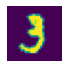

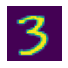

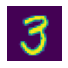

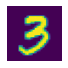

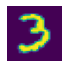

In [12]:
for i in range(5):
    show_image(three_tensors[i])

##### Creating a stack containing all our images

In [13]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

##### The length of a tensor’s shape is its rank:

In [14]:
print(len(stacked_threes.shape))
print(stacked_threes.ndim)

3
3


##### Mean pixel value for "3" and "7"

<AxesSubplot:>

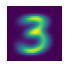

In [15]:
mean3 = stacked_threes.mean(0)
show_image(mean3)

<AxesSubplot:>

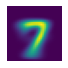

In [16]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

##### Let's check our approach using: 
* Mean absolute difference or L1 norm
* root mean squared error (RMSE) or L2 norm

<AxesSubplot:>

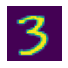

In [17]:
a_3 = stacked_threes[1]
show_image(a_3)

In [18]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [19]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs, dist_7_sqr

(tensor(0.1586), tensor(0.3021))

Or the similar way (torch.nn.functional as F)

In [20]:
F.l1_loss(a_3.float(), mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

##### Use our valid dataset

In [21]:
valid_3_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o))
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

##### Create loss function

In [22]:
def mnist_distance(a, b):
    return (a - b).abs().mean((-1, -2))

In [23]:
mnist_distance(a_3, mean3)

tensor(0.1114)

##### Instead of checking all the images with a loop statement, we can use the next code:

The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use
broadcasting: it will automatically expand the tensor with the smaller rank to have
the same size as the one with the larger rank. Broadcasting is an important capability
that makes tensor code much easier to write.

In [24]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

In [25]:
def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [26]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [29]:
is_3(valid_3_tens)

tensor([ True,  True,  True,  ..., False,  True,  True])

In [30]:
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))